In [1]:
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pydse.arma import minic, ARMA
from pydse.utils import make_lag_arr
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
from pylab import rcParams
import numpy as np
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()



In [2]:
def mse(y_actual, y_predicted, print_val=True):
    """
    Args:
    -----
    y_actual - Array of actual target values
    y_predicted - Array of predicted target values
    print_val - If `True` (default), RMSE will be
                printed. Otherwise, it will be 
                returned.
    """
    err = mean_squared_error(y_actual, y_predicted)
    if print_val:
        print('MSE: {:,.4f}'.format(err))
    else:
        return err
    
    
def plot_forecast(actual, pred, title='Actual vs Forecast', 
                  xlabel='Date', ylabel='Subway Entry Counts', 
                  grid=True, figsize=(10, 5)):
    
    if len(actual) != len(pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(actual))
        return_str += '{} forecast)'.format(len(pred))
        return return_str
    
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, pred, label='Predicted', c='r')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
#     plt.xticks(actual.index.date, 
#                actual.index.day)
    plt.xlim(min(actual.index.date), max(actual.index.date))
    plt.legend(loc=0)
    plt.grid(True)

In [121]:
df_all = pd.read_csv("../Data/Taxi_Data/new_taxi.csv")
df_all['date'] = df_all['pickup_datetime']
df_all.set_index('date', inplace=True)
df_all = df_all[['passenger_count']]

df_preCovid = df_all[df_all.index < '2020-03-01']
df_preCovid_train = df_preCovid[df_preCovid.index < '2019-11-01']
df_preCovid_test = df_preCovid[~(df_preCovid.index < '2019-11-01')]
df_postCovid = df_all[~(df_all.index < '2020-03-01')]

In [122]:
df_preCovid.head(2)

,passenger_count
date,
2015-01-01,77789
2015-01-02,61832


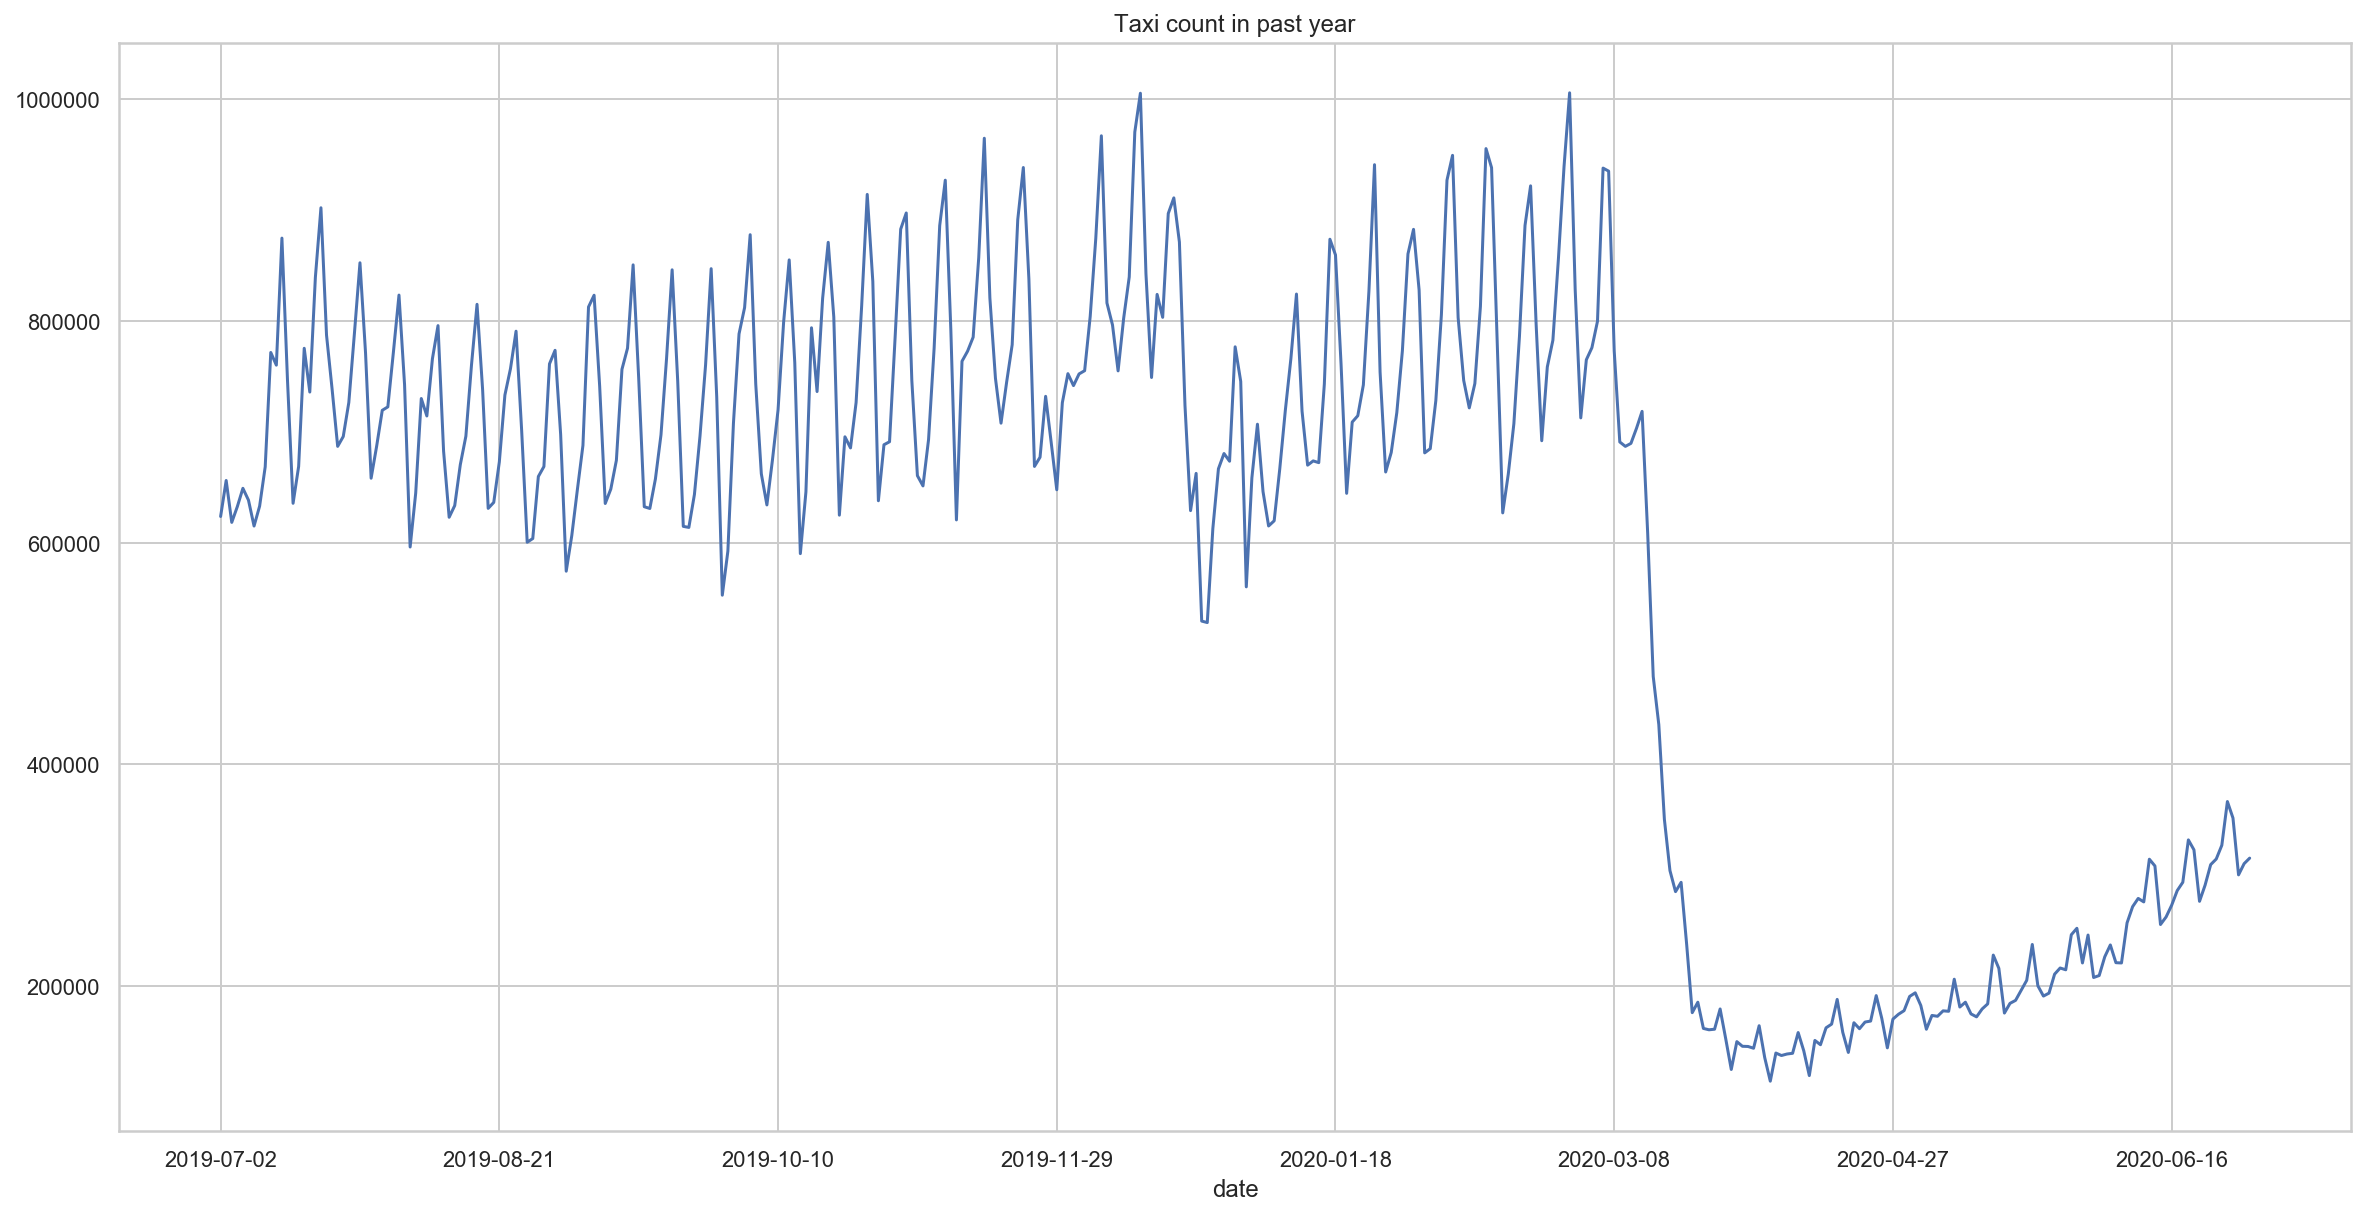

In [123]:
plt.figure(figsize=(20,10))
plt.title("Taxi count in past year")
df_all["passenger_count"][-365:].plot()
plt.show()

## Standardize

In [124]:
# standardize the data 
scaler = StandardScaler()
scaler.fit(df_preCovid_train)
print(scaler.mean_)
df_preCovid_train['entries_scaled'] = scaler.transform(df_preCovid_train)
df_preCovid_test['entries_scaled'] = scaler.transform(df_preCovid_test) 
df_postCovid['entries_scaled'] = scaler.transform(df_postCovid)

[452517.28895184]


/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [125]:
df_preCovid_train = df_preCovid_train[['entries_scaled']]
df_preCovid_test = df_preCovid_test[['entries_scaled']]
df_preCovid_full = pd.concat([df_preCovid_train, df_preCovid_test])

In [126]:
df_postCovid = df_postCovid[['entries_scaled']]

In [127]:
df_preCovid_train.index = pd.to_datetime(df_preCovid_train.index)
df_preCovid_test.index = pd.to_datetime(df_preCovid_test.index)
df_preCovid_full.index = pd.to_datetime(df_preCovid_full.index)
df_postCovid.index = pd.to_datetime(df_postCovid.index)

In [128]:
df_all = pd.concat([df_preCovid_full, df_postCovid])
df_all

,entries_scaled
date,
2015-01-01,-1.776930
2015-01-02,-1.852597
2015-01-03,-1.757175
2015-01-04,-1.848524
2015-01-05,-1.808824
...,...
2020-06-26,-0.407341
2020-06-27,-0.477754
2020-06-28,-0.720626


## Find gaps in timeseries

In [129]:
def find_gaps(df):
    df.reset_index(inplace=True)
    df["timediff"] = (df['date'] - df['date'].shift(1)) / np.timedelta64(1, 'D')
    print(df['timediff'].value_counts())
    df.set_index('date', inplace=True)
    
    return df

In [130]:
df_all.index = pd.to_datetime(df_all.index)

In [131]:
df_all = find_gaps(df_all)

# only have 1 day interval so good

1.0    2007
Name: timediff, dtype: int64


/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


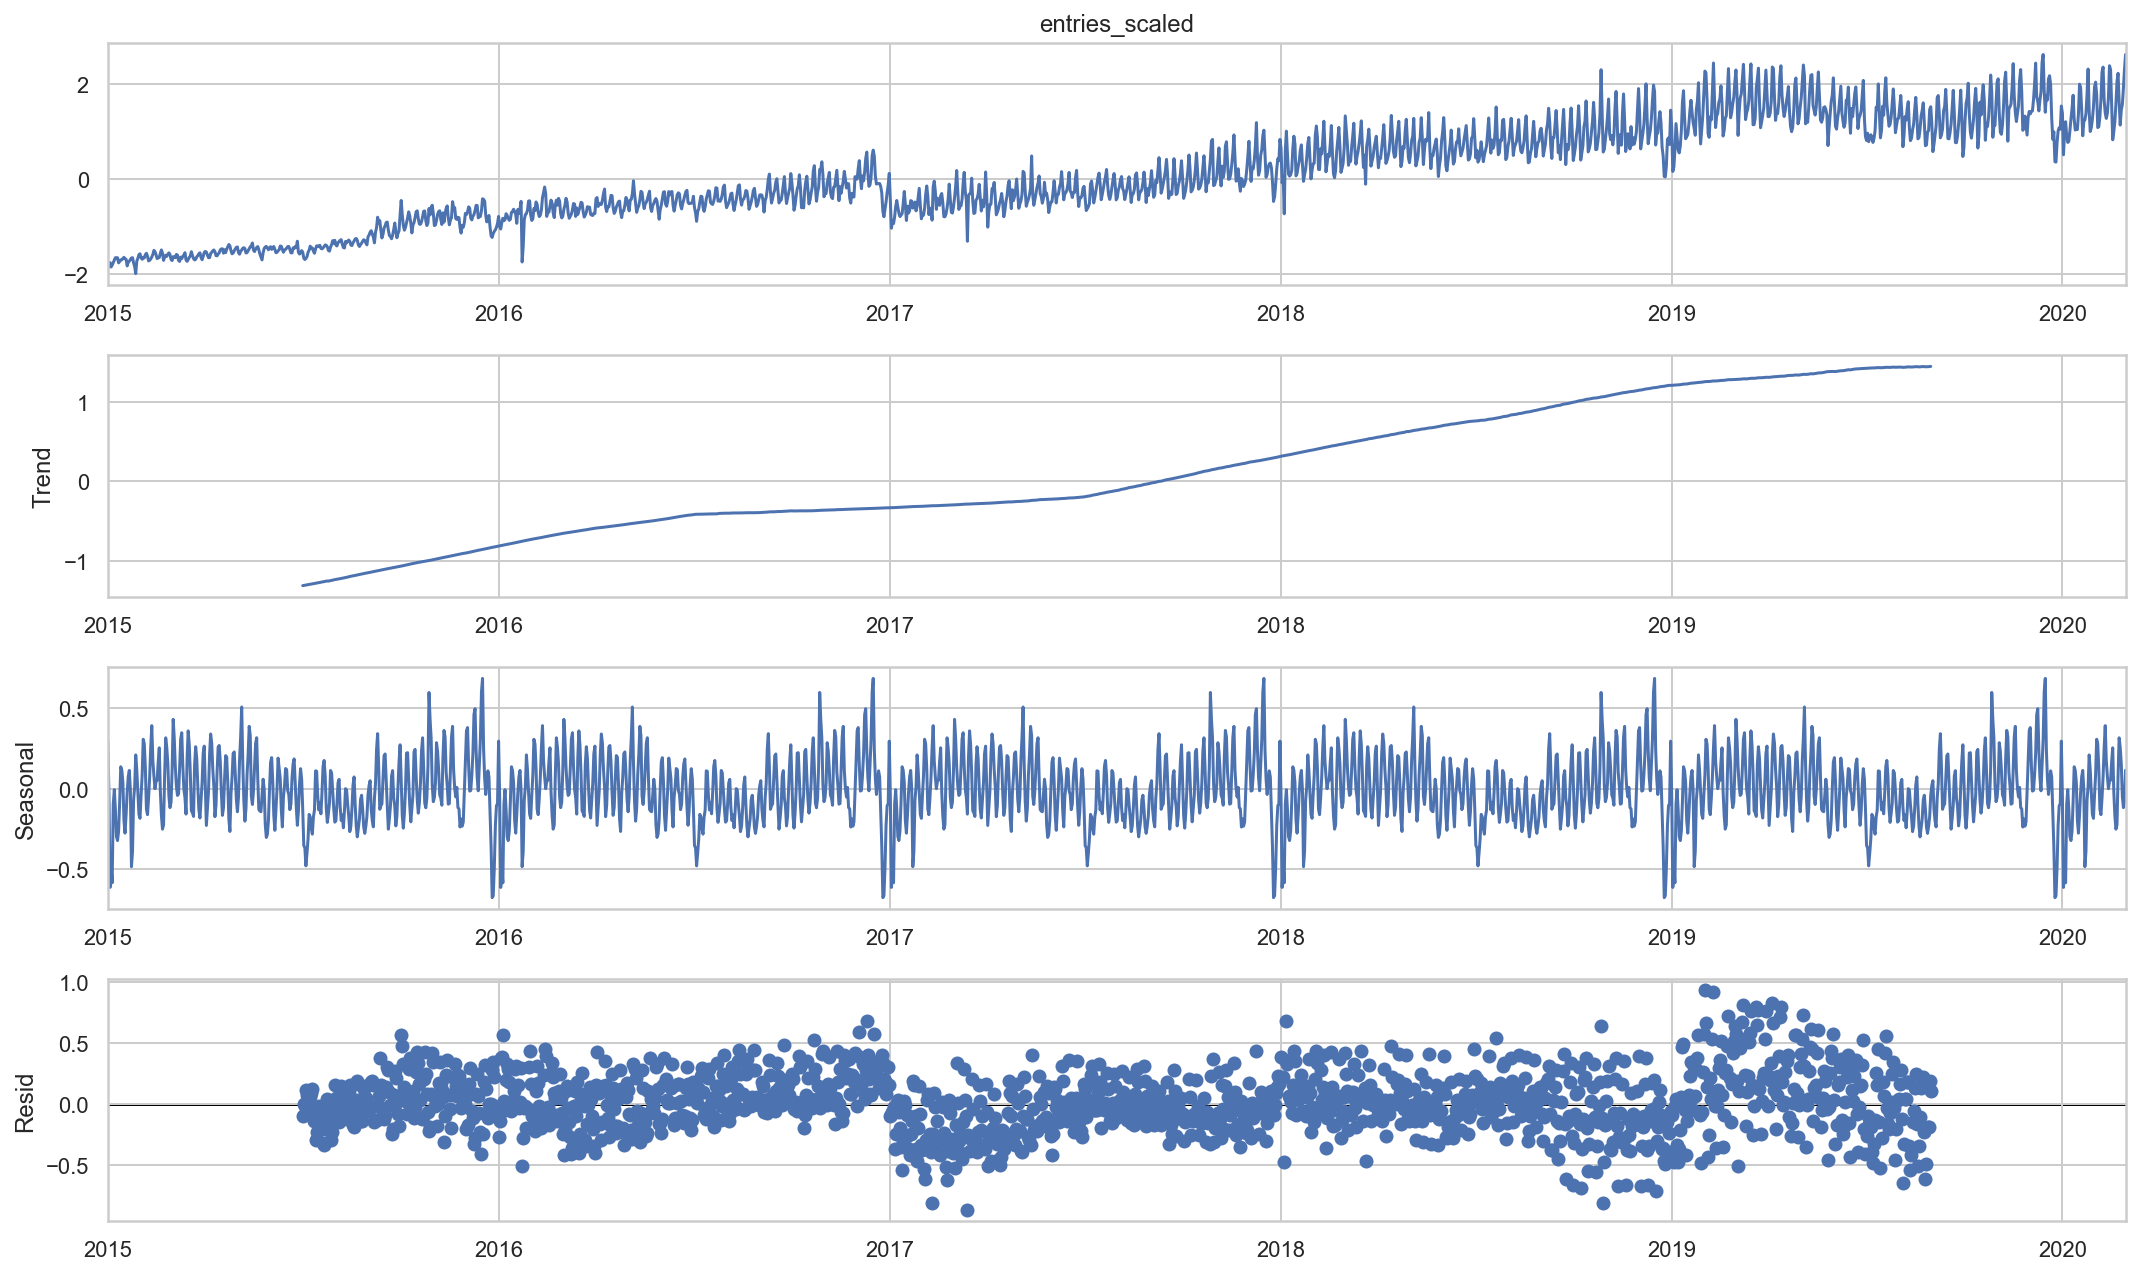

In [132]:
rcParams['figure.figsize'] = 15, 9
decomposition = seasonal_decompose(df_preCovid_full['entries_scaled'], model='additive', freq=365)
decomposition.plot()
plt.show()

In [133]:
train_values = decomposition.observed[:'2019-10-31']
train_seasonal = decomposition.seasonal[:'2019-10-31']

In [134]:
test_values = decomposition.observed['2019-11-01':'2020-02-29']
test_seasonal = decomposition.seasonal['2019-11-01':'2020-02-29']

### get trend

In [135]:
X_train = np.c_[np.arange(len(df_preCovid_train))]
y_train = df_preCovid_train['entries_scaled']

X_full = np.c_[np.arange(len(df_all))]
print(len(X_train), len(y_train), len(X_full))

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)    

#save trend for the entire period in df_all dataframe
df_all['trend'] = linreg.predict(X_full)


1765 1765 2008


In [136]:
preCovid_train_trend = df_all['trend'][:'2019-10-31']
preCovid_test_trend = df_all['trend']['2019-11-01':'2020-02-29']
postCovid_trend = df_all['trend']['2020-03-01':'2020-06-30']

### get resid

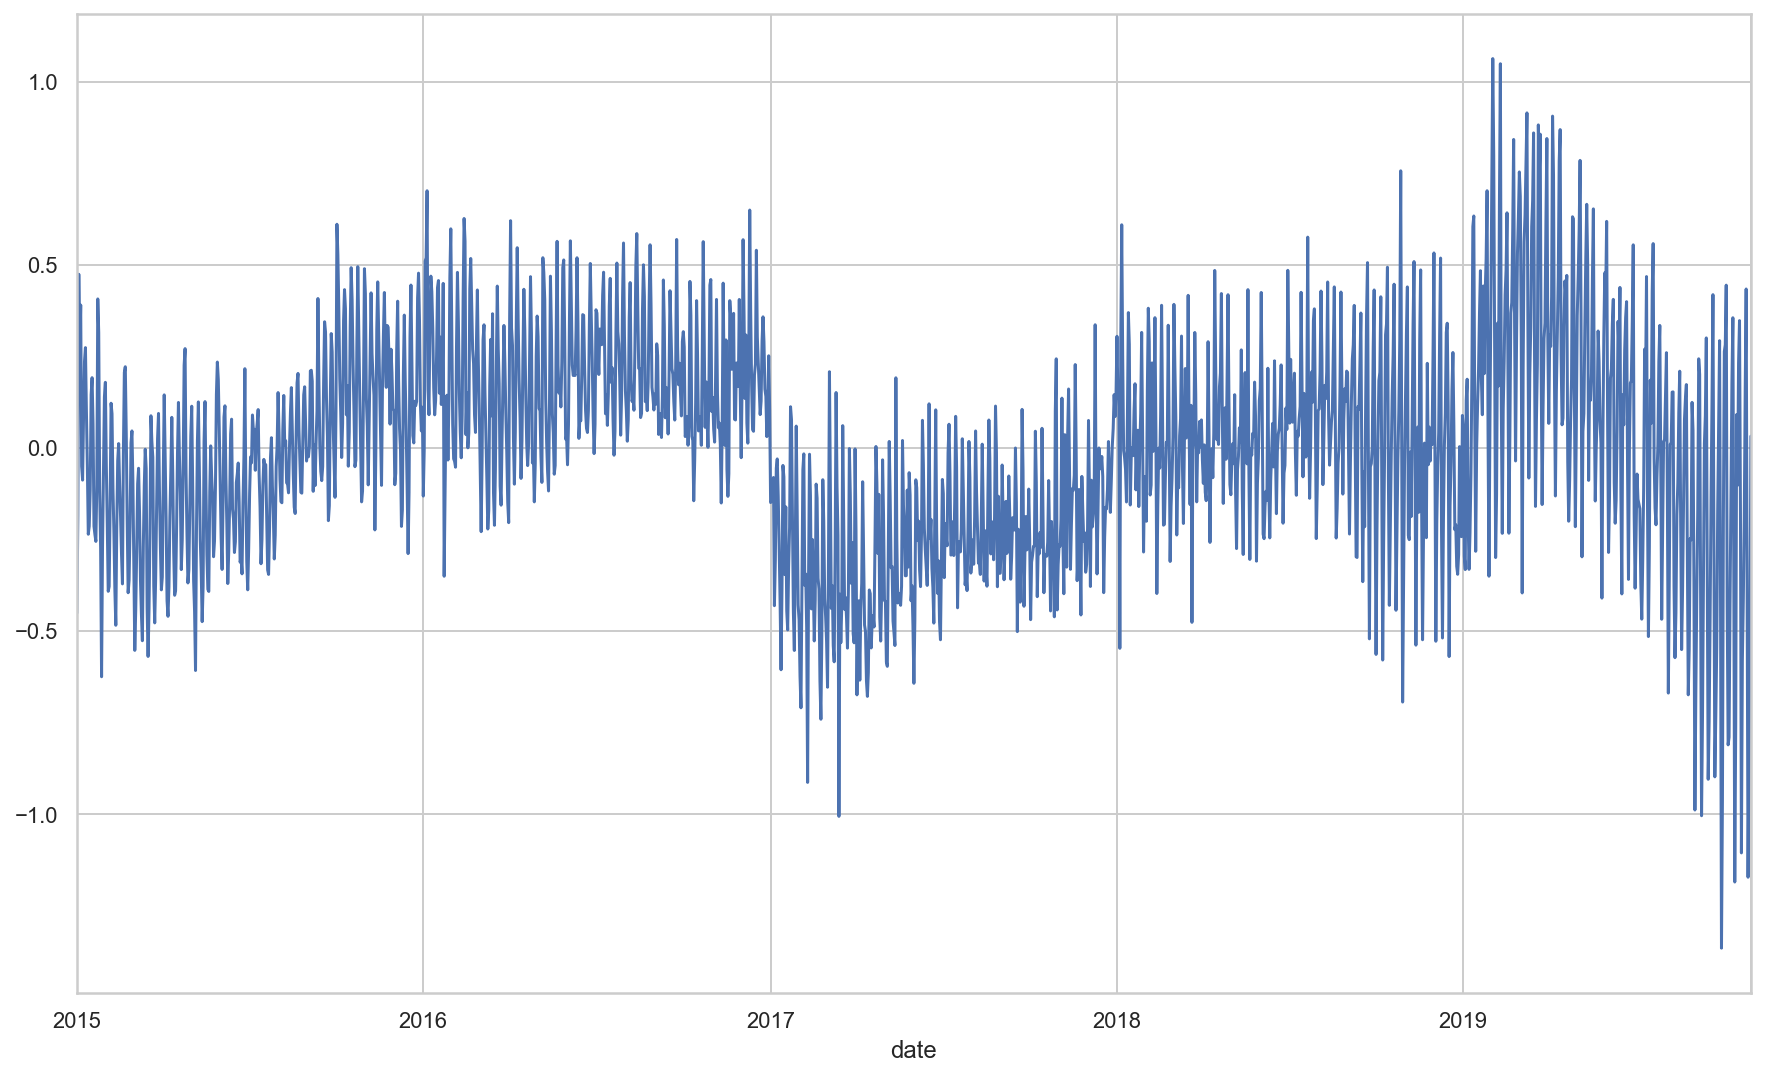

In [137]:
df_preCovid_train['resid'] = train_values - train_seasonal - preCovid_train_trend.values
df_preCovid_train['resid'].plot()
plt.show()

### Find best ar, ma lag

In [138]:
best_ar_lags, best_ma_lags = minic([1], [1, 2, 3], np.asarray(df_preCovid_train['resid']), crit='AIC')
print(best_ar_lags, best_ma_lags)

(1,) (2, 3)


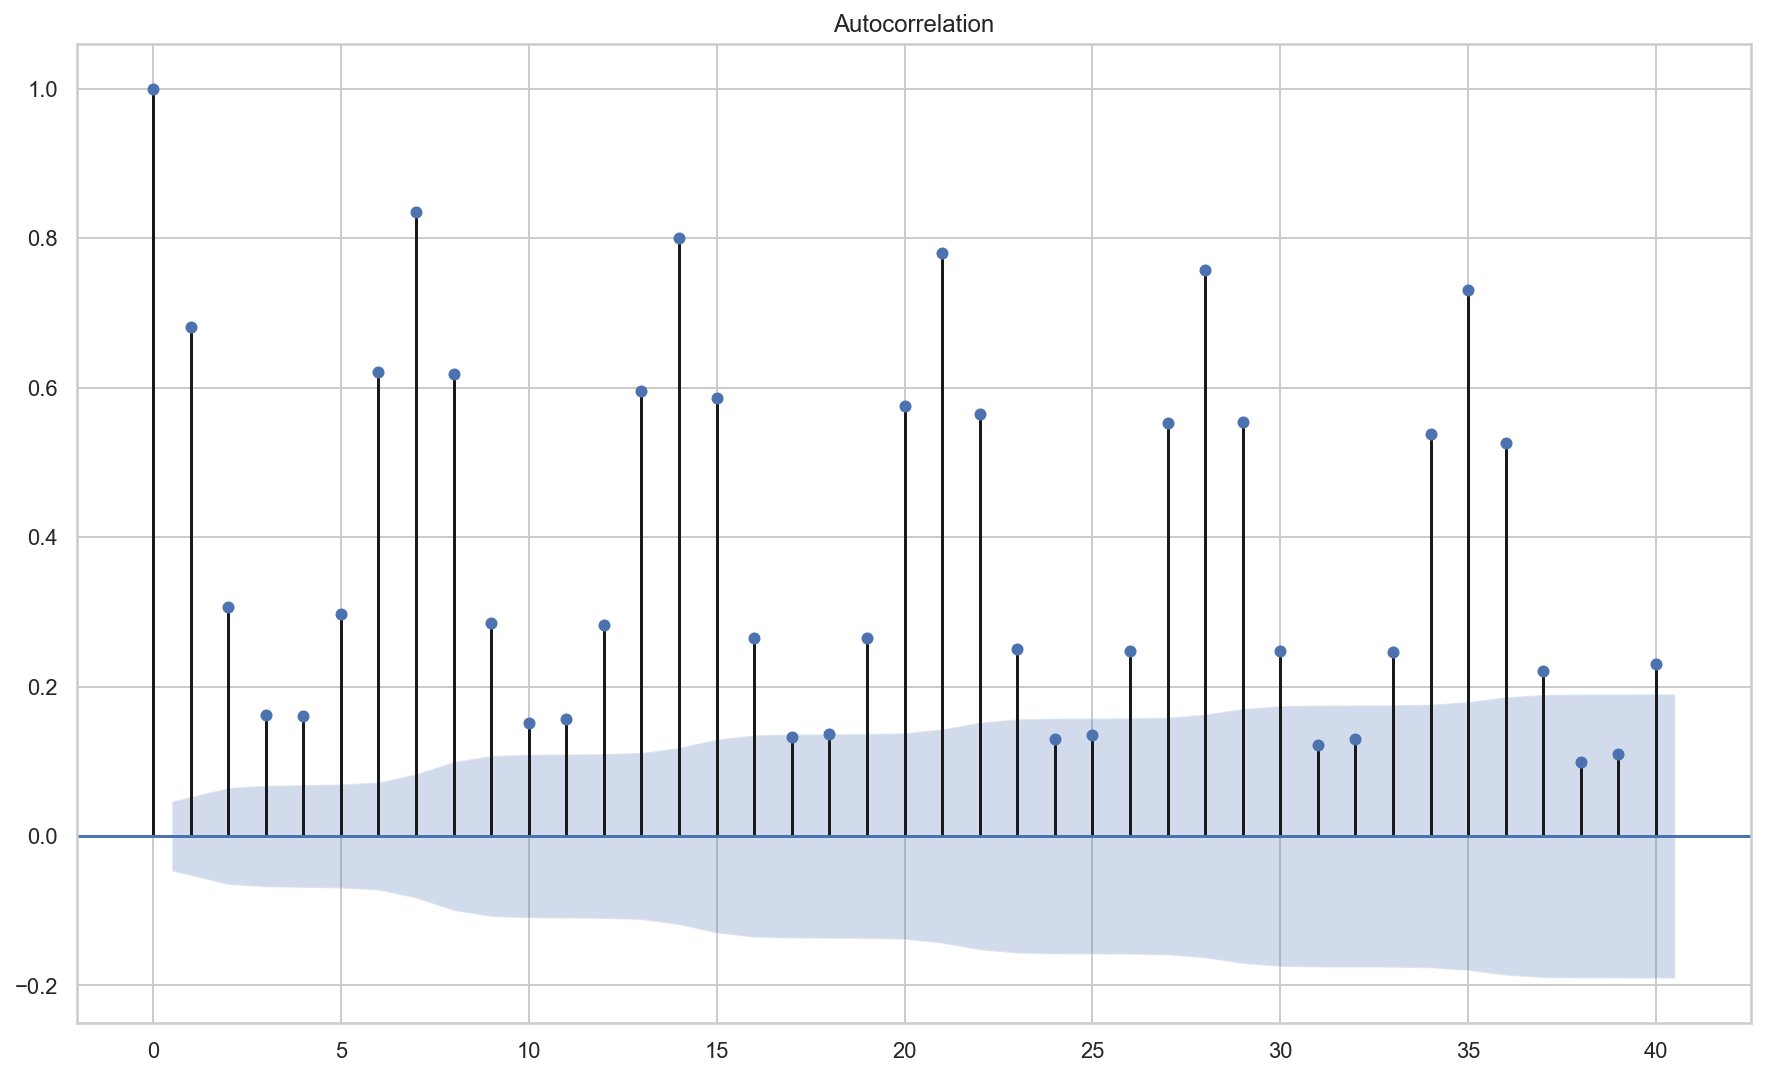

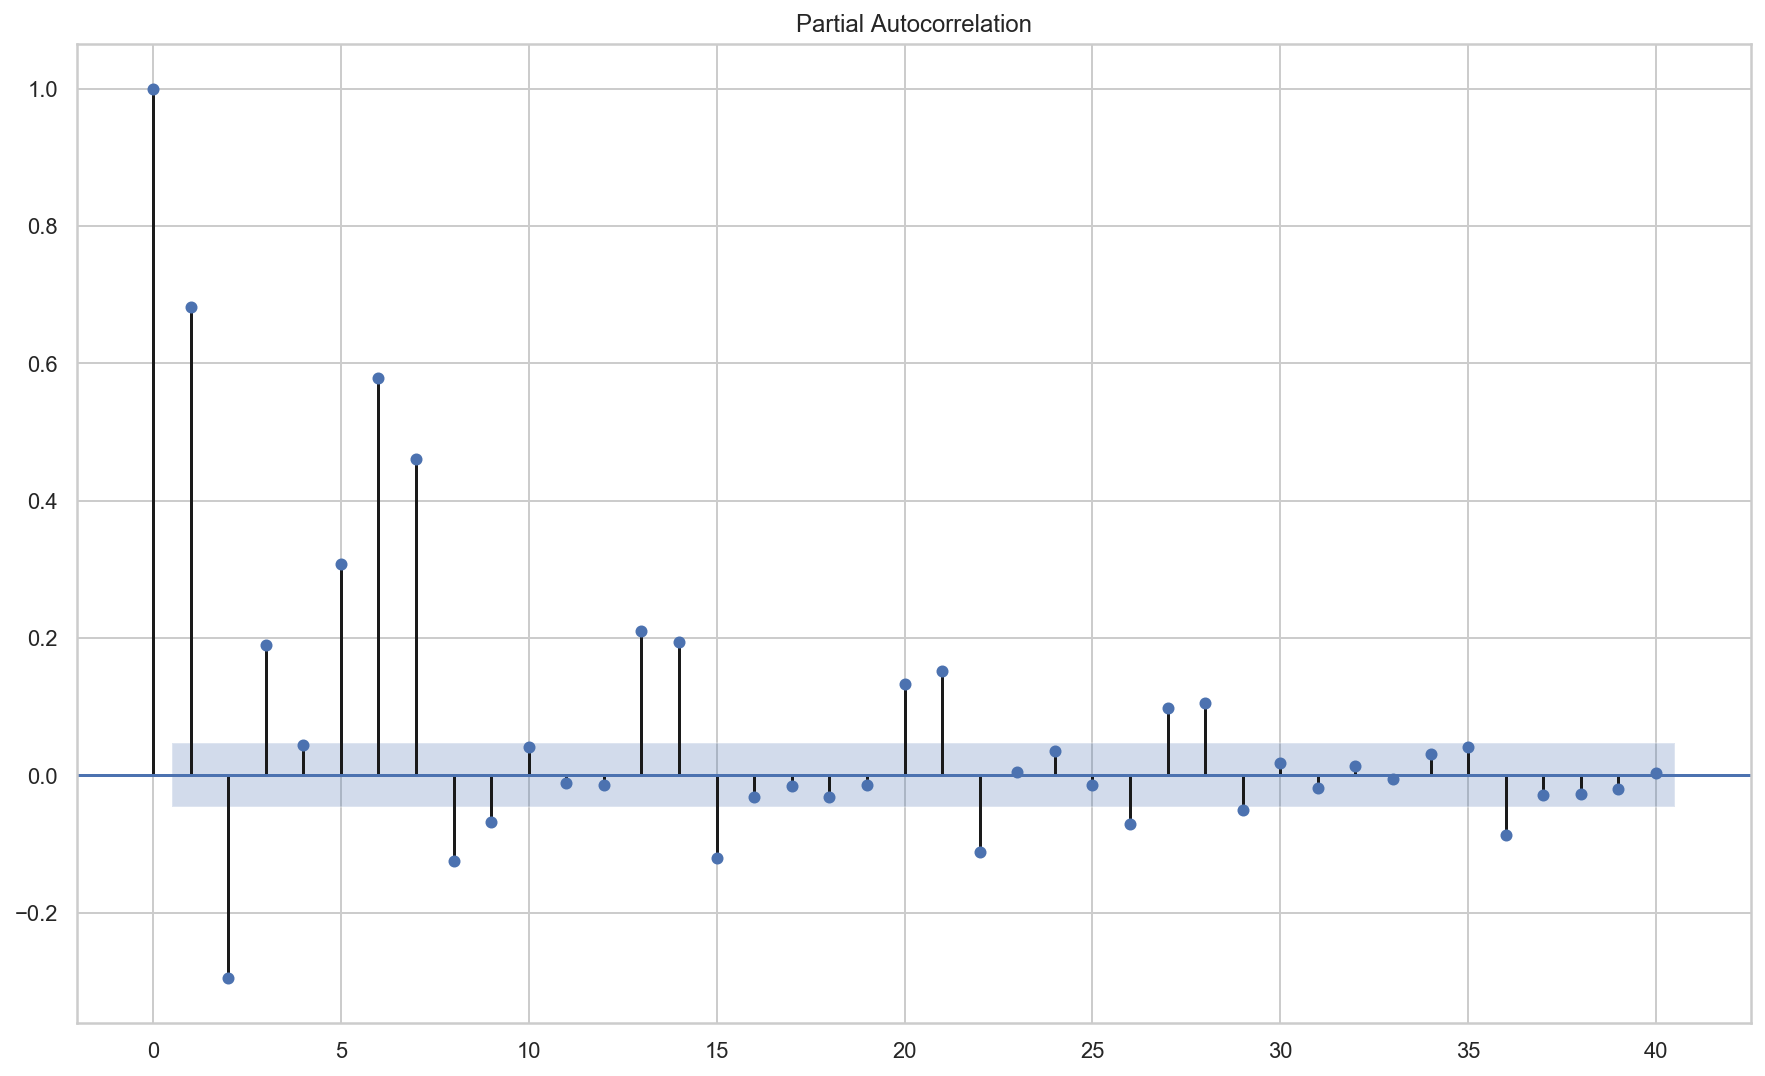

In [139]:
plot_acf(df_preCovid_train['resid'], lags=40)
plt.show()

plot_pacf(df_preCovid_train['resid'], lags=40)
plt.show()

### ARIMA(0,0,2)

In [140]:
arima = ARIMA(df_preCovid_train['resid'], order=(1,0,3), freq='D')
arima_res = arima.fit()

/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [141]:
arima_res.fittedvalues

date
2015-01-01   -0.032080
2015-01-02   -0.336566
2015-01-03   -0.092013
2015-01-04    0.370913
2015-01-05   -0.024230
                ...   
2019-10-27    0.153691
2019-10-28   -0.576020
2019-10-29   -0.817368
2019-10-30   -0.386228
2019-10-31   -0.390922
Length: 1765, dtype: float64

## train mse

In [142]:
train_pred = arima_res.fittedvalues + train_seasonal + preCovid_train_trend.values

MSE: 0.0372


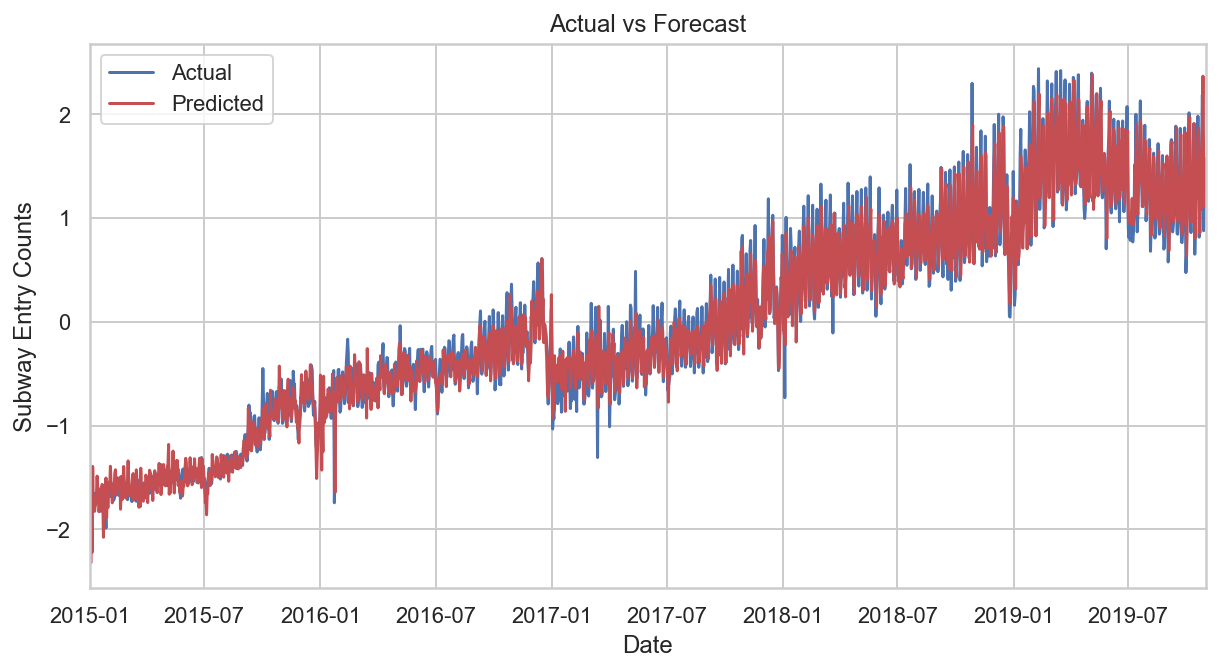

In [143]:
plot_forecast(df_preCovid_train['entries_scaled'], train_pred)
mse(df_preCovid_train['entries_scaled'], train_pred)

## test mse

In [144]:
test_pred_residual = arima_res.predict(start='2019-11-01', end='2020-02-29')

In [145]:
test_pred = test_pred_residual + test_seasonal + preCovid_test_trend

MSE: 0.2234


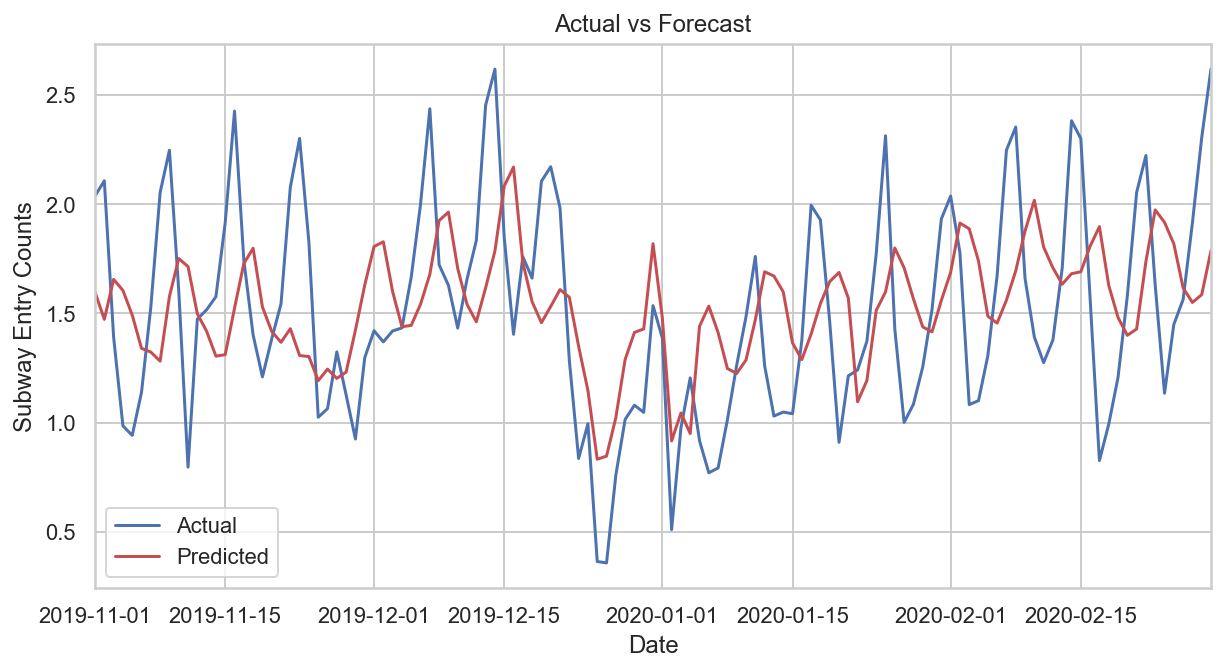

In [146]:
plot_forecast(test_values, test_pred)
mse(test_values, test_pred)

## postCovid MSE

In [147]:
postCovid_seasonal = decomposition.seasonal['2019-03-03':'2019-07-02']
len(postCovid_seasonal)

122

In [148]:
postCovid_pred_residual = arima_res.predict(start='2020-03-01', end='2020-06-30')
postCovid_pred = postCovid_pred_residual + postCovid_trend + postCovid_seasonal.values

MSE: 8.0067


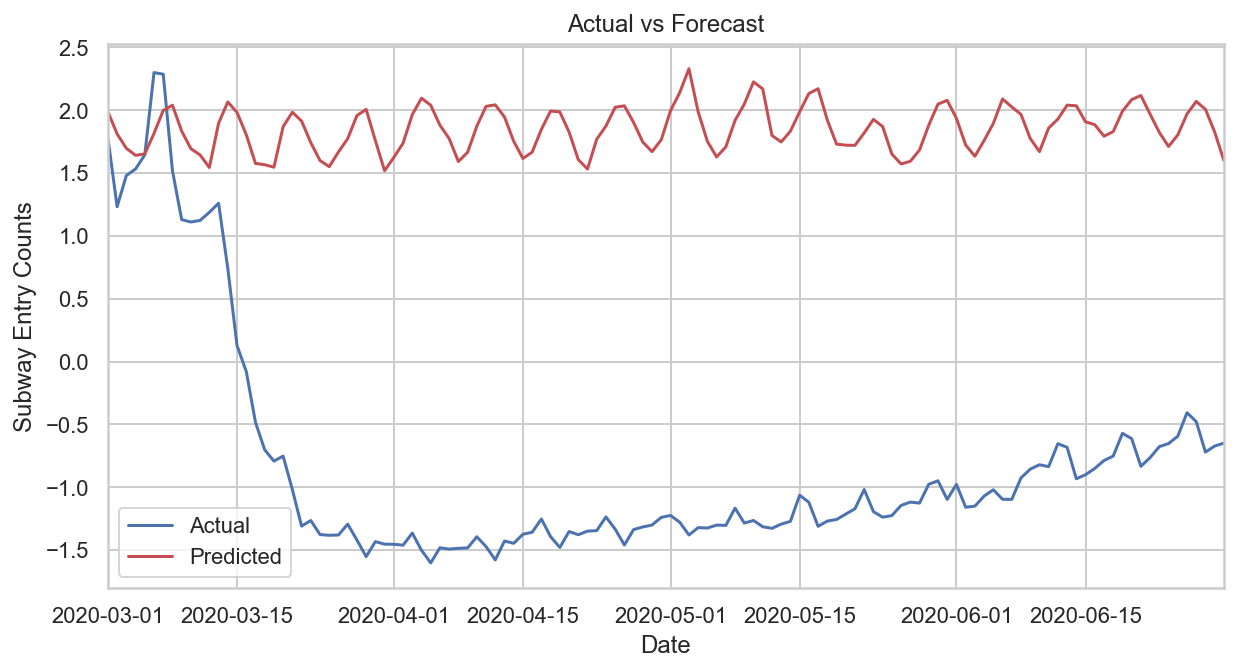

In [149]:
plot_forecast(df_postCovid['entries_scaled'], postCovid_pred)
mse(df_postCovid['entries_scaled'], postCovid_pred)

## Plot Combined preCovid+TestCovid

In [150]:
actual = pd.concat([test_values, df_postCovid['entries_scaled']])
pred =  pd.concat([test_pred, postCovid_pred])

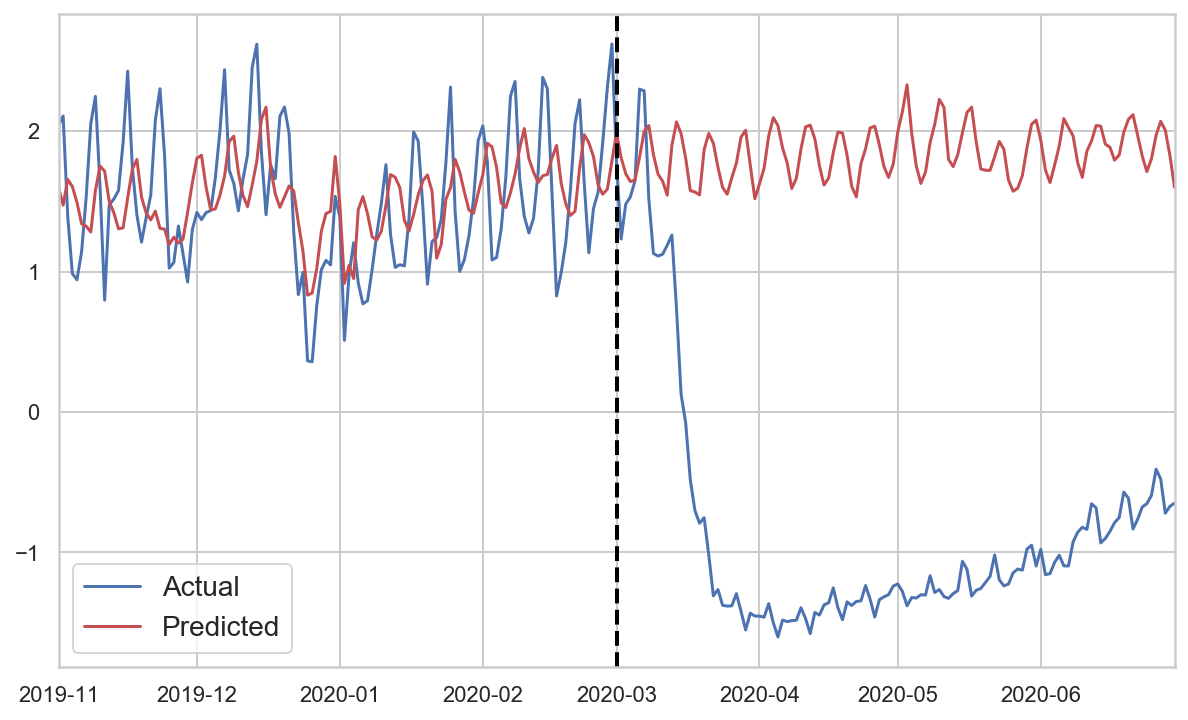

In [151]:
plt.figure(figsize=(10,6))
plt.plot(actual, label='Actual')
plt.plot(actual.index, pred, label='Predicted', c='r')
plt.axvline(pd.Timestamp('2020-03-01'),color='black', ls='--', lw=2)

# plt.xticks(actual.index.date, 
#            actual.index.day)
plt.xlim(min(actual.index.date), max(actual.index.date))
plt.legend(loc=0, fontsize = 14)
plt.grid(True)
